# STEAM basis spectra creation
This notebook creates a basis set for the 40 ms diffusion-STEAM sequence used to created dataset 1, and described in [this documentation](https://github.com/dwmrshub/pregame-workshop-2021/blob/main/InVivo-Data/Data1/DW-STEAM_readme). 

You will need:
1. A copy of [FSL-MRS](https://open.win.ox.ac.uk/pages/fsl/fsl_mrs/install.html)
2. A copy of the `pregame` data `git clone https://github.com/dwmrshub/pregame-workshop-2021.git`
3. A copy of the Bloch simulator used `git clone https://github.com/wexeee/bloch-simulator-python.git`

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Load the chronogram
Load one of the chronograms containing the pulse amplitude modulations and gradients.
Each point is 6.4 us.


In [2]:
chrono_g10_dir1 = pd.read_csv('../pregame-workshop-2021/InVivo-Data/Data1/chronogram/chronogram_G15_dir1.csv')

# Timings
chrono_g10_dir1.index = chrono_g10_dir1.index*6.4/1000
chrono_g10_dir1

Gx   Gy   Gz   RF
0.0000    0.000000  0.0  0.0  0.0
0.0064    0.114971  0.0  0.0  0.0
0.0128    0.229941  0.0  0.0  0.0
0.0192    0.344912  0.0  0.0  0.0
0.0256    0.459883  0.0  0.0  0.0
...            ...  ...  ...  ...
127.9552  0.000000  0.0  0.0  0.0
127.9616  0.000000  0.0  0.0  0.0
127.9680  0.000000  0.0  0.0  0.0
127.9744  0.000000  0.0  0.0  0.0
127.9808  0.000000  0.0  0.0  0.0

[19998 rows x 4 columns]

Plot the traces

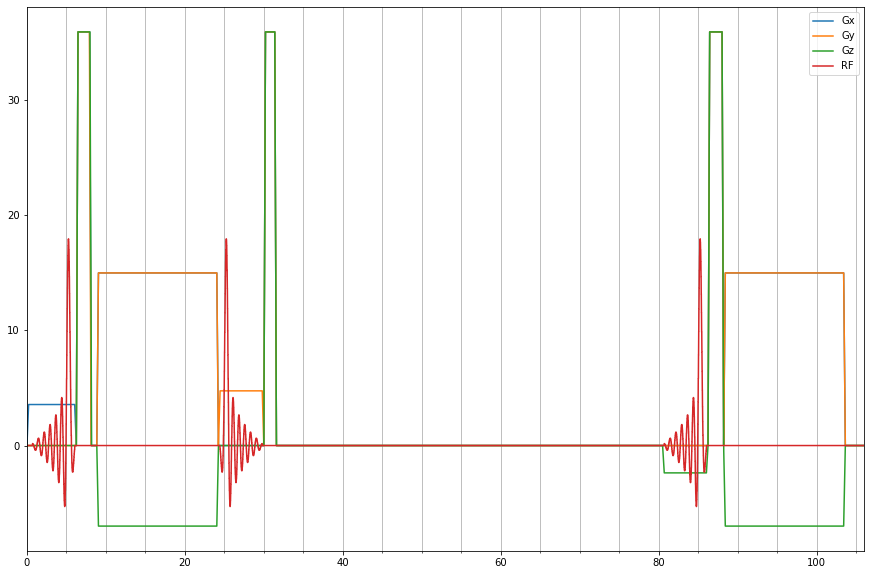

In [3]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig = plt.figure(figsize=(15,10))
chrono_g10_dir1.plot(ax=fig.gca())
fig.gca().xaxis.set_major_locator(MultipleLocator(20))
fig.gca().xaxis.set_major_formatter('{x:.0f}')
fig.gca().xaxis.set_minor_locator(MultipleLocator(5))

plt.grid(which='both', axis='x')
plt.xlim([0,106])
plt.show()

## Find the RF regions
Identify the regions where RF is on, extract the traces in those regions, and create complex pulse descriptions.

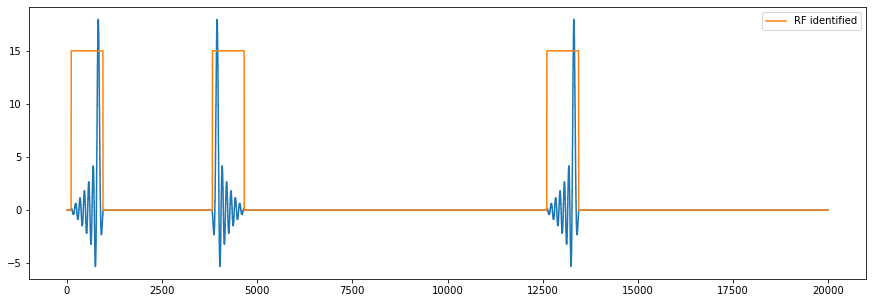

In [6]:
rf_array = chrono_g10_dir1['RF'].to_numpy()

def my_key(x):
    return x[1]==0.0
rf_indicies = [[i for i,value in it] for key,it in itertools.groupby(enumerate(rf_array), key=my_key) if key == False]

fig = plt.figure(figsize=(15,5))
plt.plot(rf_array)
index_plot = np.zeros_like(rf_array)
for rf_ind in rf_indicies:    
    index_plot[rf_ind]=15
plt.plot(index_plot,label='RF identified')
plt.legend()
plt.show()


In [7]:
# Extract regions of RF, and gradient modulation
rf_amps = []
rf_grads = []
rf_amp_array = chrono_g10_dir1['RF'].to_numpy()
gx_array = chrono_g10_dir1['Gx'].to_numpy()
gy_array = chrono_g10_dir1['Gy'].to_numpy()
gz_array = chrono_g10_dir1['Gz'].to_numpy()
rf_duration = []
tp = 6.4E-6 

for rf_ind in rf_indicies:    
    rf_amps.append(rf_amp_array[rf_ind])
    rf_grads.append(np.stack((gx_array[rf_ind], gy_array[rf_ind], gz_array[rf_ind])).T)
    rf_duration.append(tp*len(rf_ind))

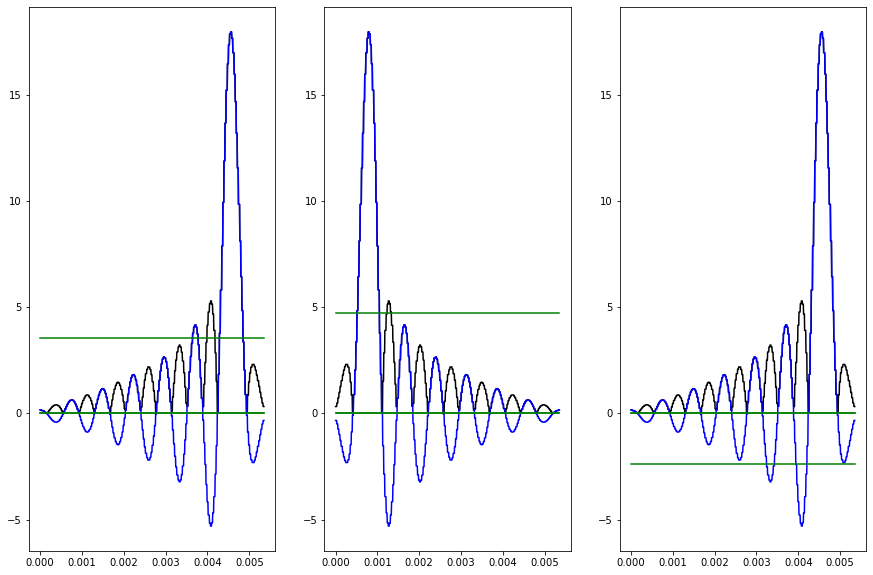

In [8]:
# Construct Complex pulse descriptions
rf_complex = rf_amps
    
# Plot
fig, axes = plt.subplots(1,3,figsize=(15,10))
for ax, rfc, rfg, ta in zip(axes.flatten(), rf_complex, rf_grads, rf_duration):
    taxis = np.linspace(0,ta,num=rfc.size)
    ax.plot(taxis,np.abs(rfc),'k')
    ax.plot(taxis,np.real(rfc),'b')
    ax.plot(taxis,np.real(rfg),'g')

Calculate the centroid of the RF pulse for TE and rephase calculations

0.15


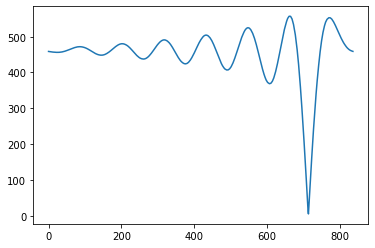

In [10]:
plt.plot(np.abs(np.cumsum(rf_complex[0])-np.sum(rf_complex[0])/2))
centroid = taxis[np.argmin(np.abs(np.cumsum(rf_complex[0])-np.sum(rf_complex[0])/2))]
centroid_frac = 1- (centroid/taxis[-1])
cetroid_frac = np.round(centroid_frac,2)
print(cetroid_frac)

## Simulate the pulse
Pulse is simulated using a Python version of Brian Hargreaves' Bloch simulator. As ever, thank you Brian!

Simulate the 90 over a range of offsets and positions to ensure it is working as expected.

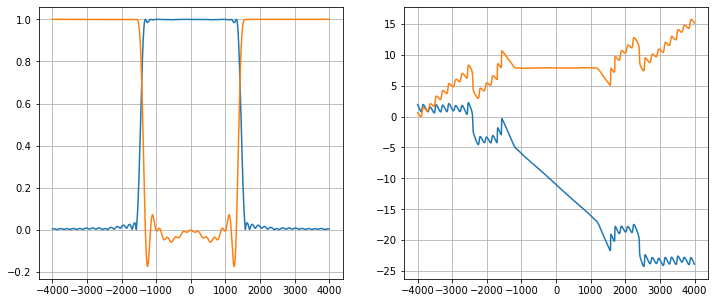

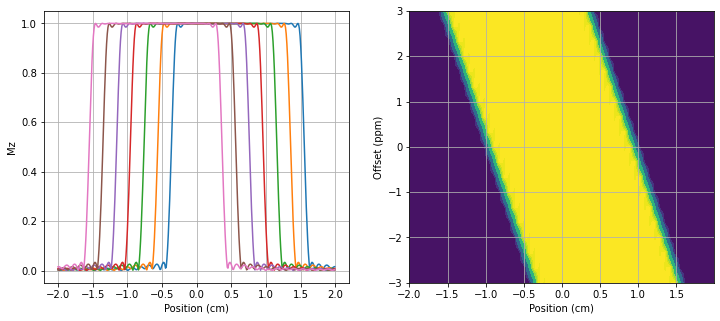

In [11]:
# Simulation of pulses
from bloch.bloch import bloch

#Excitation pulse
exc_pulse_hz = rf_complex[0] * 42.5774
exc_pulse_hz_rev = rf_complex[1] * 42.5774
exc_pulse_dur = rf_duration[0]
g = np.zeros(exc_pulse_hz.shape)

dt = exc_pulse_dur / exc_pulse_hz.size
t1 = 5.0
t2 = 5.0

dp = 0
df = np.arange(-4000,4000,5, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(exc_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(df,np.abs(mx+1j*my))
ax1.plot(df,mz)
ax1.grid()

mxy = (mx+1j*my).squeeze()
ax2.plot(df,np.unwrap(np.angle(mxy)))
centroid_time = exc_pulse_dur * 0.15
phase_factor = np.exp(1j * 2 * np.pi * df * centroid_time)
ax2.plot(df,np.unwrap(np.angle(phase_factor*(mxy))))
ax2.grid()
plt.show()

g_inhzpercm = rf_grads[0][0][0] * 42.5774 * 1000/100  # 1000 is mT->T and 100 is m->cm
g = g_inhzpercm * np.ones(exc_pulse_hz.shape)

dp = np.arange(-2,2,0.01, dtype=float)
df = np.arange(-900,901,100, dtype=float)
mode = 0

mx_0 = 0
my_0 = 0
mz_0 = 1

mx, my, mz = bloch(exc_pulse_hz, g, dt, t1, t2, df, dp, mode, mx_0, mx_0, mx_0)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(dp,np.abs(mx+1j*my).T[:,::3])
ax1.set_xlabel('Position (cm)')
ax1.set_ylabel('Mz')
ax1.grid()

ax2.contourf(dp,df/300,np.abs(mx+1j*my),levels=[0, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99,1.0])
ax2.set_xlabel('Position (cm)')
ax2.set_ylabel('Offset (ppm)')
ax2.grid()
plt.show()

## Assemble sequence description 

We now assemble the JSON formatted sequence description as required by `fsl_mrs_sim`.

This creates a file `dw_steam.json` which will be passed tot he simulator.

For a quick and dirty run change `json_dict["resolution"] = 3 * [60, ]` to `json_dict["resolution"] = 3 * [10, ]`.

In [81]:
import json
# Pulse frequency offsets
frequency_offset = (2.0 - 4.65) * 7.00 * 42.5774

# Uniform Gradients
# 30x15x20mm3 Voxel -> grads make it clear it is 20x15x30 mm3
gradx = rf_grads[0][1,0]
grady = rf_grads[1][1,1]
gradz = np.abs(rf_grads[2][1,2])

rephase_gradx = -gradx * rf_duration[0]*0.15
rephase_grady = -grady * rf_duration[1]*0.15
rephase_gradz = -gradz * rf_duration[2]*0.15

# Claculate delays
# Delays excludes time with RF on.
d1 = 6.4E-6 * (rf_indicies[1][0]-rf_indicies[0][-1])
d2 = 6.4E-6 * (rf_indicies[2][0]-rf_indicies[1][-1])

p1 = rf_duration[0]*0.15
p2 = rf_duration[1]*0.15
p3 = rf_duration[1]*0.85
p4 = rf_duration[2]*0.85
p5 = rf_duration[2]*0.15

TE_half = d1 + p1 + p2
TM = p3 + d2 + p4

d3 = TE_half - p5
TE_half2 = d3 + p5

# In the instruction the TE is 45 ms but the CSVs make it out to be 40 ms.

delay_vec = np.array([d1, d2, d3])

# Generate the json dict
json_dict = {}
json_dict["sequenceName"] = "dw_STEAM"
json_dict["description"] = "7T Philips DW-STEAM sequence."
json_dict["B0"] = 7.00
json_dict["centralShift"] = 4.65

# Rx parameters
json_dict["Rx_Points"] = 2*8192
json_dict["Rx_SW"] = 6000
json_dict["Rx_LW"] = 2
json_dict["Rx_Phase"] = 0.0

# Simulation spatial extent
# Simulated for a 30x15x20mm3 voxel. Double this
json_dict["x"] = [-20, 20]
json_dict["y"] = [-15, 15]
json_dict["z"] = [-30, 30]
json_dict["resolution"] = 3 * [60, ]

# Sequence description units
json_dict["RFUnits"] = "Hz"
json_dict["GradUnits"] = "mT"
json_dict["spaceUnits"] = "mm"

# Coherence filter
json_dict["CoherenceFilter"] = [1, 0, -1]

# Delays
json_dict["delays"] = delay_vec.tolist()

# Rephase areas
rp_areas = np.zeros((3, 3))
rp_areas[0, 0] = rephase_gradx
rp_areas[0, 1] = rephase_grady
rp_areas[2, 2] = rephase_gradz
json_dict["rephaseAreas"] = rp_areas.tolist()


# Assemble the RF blocks
# Each block must contain:
# "time" duration of RF.
# "frequencyOffset" offset from the centralShift in Hz
# "phaseOffset" typically 0.
# "amp" pulse amplitude modulation
# "phase" pulse phase modulation
# "grad" [x,y,z] gradient

rf_array = []
# 1. Excitation block
rf_array.append({
    "time": rf_duration[0],
    "frequencyOffset": frequency_offset,
    "phaseOffset": 0.0,
    "amp": np.abs(exc_pulse_hz).tolist(),
    "phase": np.angle(exc_pulse_hz).tolist(),
    "grad": [gradx, 0.0, 0.0]})
# 2. SE block
rf_array.append({
    "time": rf_duration[1],
    "frequencyOffset": frequency_offset,
    "phaseOffset": 0.0,
    "amp": np.abs(exc_pulse_hz_rev).tolist(),
    "phase": np.angle(exc_pulse_hz_rev).tolist(),
    "grad": [0.0, grady, 0.0]})
# 3. STE block
rf_array.append({
    "time": rf_duration[2],
    "frequencyOffset": frequency_offset,
    "phaseOffset": 0.0,
    "amp": np.abs(exc_pulse_hz).tolist(),
    "phase": np.angle(exc_pulse_hz).tolist(),
    "grad": [0.0, 0.0, gradz]})

# Generate OFF
json_dict["RF"] = rf_array

# Write the json
file_name = f'dw_steam.json'
with open(file_name, 'w') as fp:
    json.dump(json_dict, fp, indent=1)


### Create a custom set of spin systems to test the sequence.
Each system is a single spin at an integer ppm value. Quick and it will enable us to see that we get uniform, in-phase signal across a range of ppm values.

In [ ]:
%%writefile test_spinsys.json
{
"sys1": {
    "j": [[0]],
    "shifts":[1.0],
    "name": "1",
    "scaleFactor": 1.0
},
"sys15": {
    "j": [[0]],
    "shifts":[1.5],
    "name": "1_5",
    "scaleFactor": 1.0
},
"sys2": {
    "j": [[0]],
    "shifts":[2.0],
    "name": "2",
    "scaleFactor": 1.0
},
"sys25": {
    "j": [[0]],
    "shifts":[2.5],
    "name": "2_5",
    "scaleFactor": 1.0
},
"sys3": {
    "j": [[0]],
    "shifts":[3.0],
    "name": "3",
    "scaleFactor": 1.0
},
"sys35": {
    "j": [[0]],
    "shifts":[3.5],
    "name": "3_5",
    "scaleFactor": 1.0
},
"sys4": {
    "j": [[0]],
    "shifts":[4.0],
    "name": "4",
    "scaleFactor": 1.0
}
}

Now run the test simulation

In [62]:
%sx fsl_mrs_sim -s test_spinsys.json -o steam_basis_40_test -p -2.0 dw_steam.json --overwrite 

['Simulation running using mode 1d. Axis order = [0 1 2].',
 'Auto-phase adjustment. Phasing peak position = 2.65 ppm',
 'Rx_Phase: 0.0',
 'Additional phase: -2.426',
 'Final Rx_Phase: -2.426',
 'Running simulation on sys15.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys2.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys1.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys3.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys35.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on sys4.',
 'Simulation running using mode 1d. Axis order = [0 1 2].']

Load the results of the test and print.

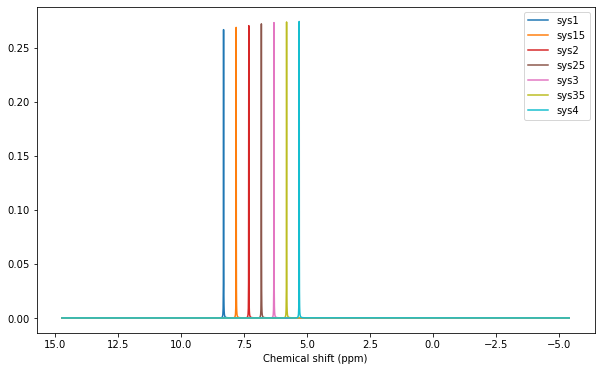

In [63]:
from fsl_mrs.utils import mrs_io
basis = mrs_io.read_basis('steam_basis_40_test/')
fig = plt.figure(figsize=(10,6))
basis.plot()
# plt.xlim([5.0,0.2])
plt.show()

## Now run the actual simulation
The simulation will use the metabolites listed in `metabs.txt`.

In [82]:
%sx fsl_mrs_sim -b metabs.txt -o steam_basis_40 -p -2.0 dw_steam.json --overwrite 

["Identified spinsystems: ['Ala', 'Asc', 'Asp', 'GPC', 'PCh', 'Cr', 'PCr', 'GABA', 'Glc', 'Gln', 'Glu', 'GSH', 'Ins', 'Lac', 'NAA', 'NAAG', 'PE', 'Scyllo', 'Tau']",
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Auto-phase adjustment. Phasing peak position = 2.65 ppm',
 'Rx_Phase: 0.0',
 'Additional phase: -2.426',
 'Final Rx_Phase: -2.426',
 'Running simulation on Cr.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on Scyllo.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on Asc.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on Gln.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on Lac.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Running simulation on NAA.',
 'Simulation running using mode 1d. Axis order = [0 1 2].',
 'Simulation running using mode 1

### View the results
To simplify the code in the practical notebooks we conjugate the basis set here to get the correct phase/frequency convention.

A copy is saved back out.

In [83]:
from fsl_mrs.utils import mrs_io
from fsl_mrs.utils import basis_tools as btools

basis = mrs_io.read_basis('steam_basis_40/')
mod_basis = btools.conjugate_basis(basis)

mod_basis.save('steam_basis_40_conj')

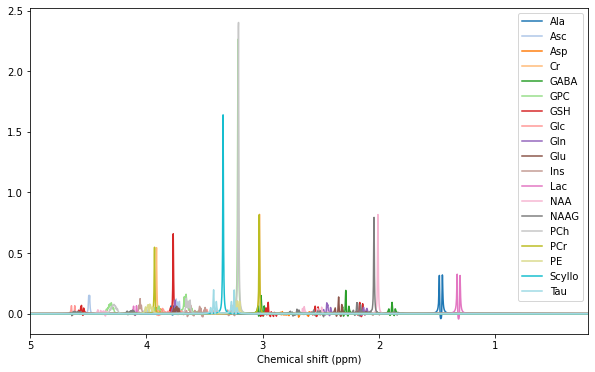

In [79]:
fig = plt.figure(figsize=(10,6))
mod_basis.plot()
plt.xlim([5.0,0.2])
plt.show()